In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets 

import gc
import matplotlib.pyplot as plt

In [2]:
# Preparaing the dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))]
)

dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)

dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=False)

In [3]:
# Generator network

class Generator(nn.Module):
    def __init__(self, noise_channel, image_channel):
        super().__init__()
        
        self.g_theta = nn.Sequential(
            # 1x1 -> 7x7
            nn.ConvTranspose2d(noise_channel, 512, 7, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            
            # 7x7 -> 14x14
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            # channel reduction
            nn.ConvTranspose2d(64, image_channel, 3, 1, 1, bias=False),
            nn.Tanh() # output: [-1, 1]
        )
        
    def forward(self, z):
        return self.g_theta(z)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super().__init__()
        
        # self.D_w = nn.Sequential(
        #     nn.Linear(image_dim, 512),
        #     nn.LeakyReLU(),
        #     nn.Linear(512, 256),
        #     nn.LeakyReLU(),
        #     nn.Linear(256, 1),
        #     nn.Sigmoid() # To get the probability value b/n [0, 1]
        # )

        self.D_w = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # x = x.squeeze().view(len(x), -1)
        return self.D_w(x)


In [5]:
torch.cuda.set_device(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
device
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 4070


In [6]:
generator = Generator(150, 1).to(device)
discriminator = Discriminator(784).to(device)

generator, discriminator

(Generator(
   (g_theta): Sequential(
     (0): ConvTranspose2d(150, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.01)
     (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(negative_slope=0.01)
     (6): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): LeakyReLU(negative_slope=0.01)
     (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (10): Tanh()
   )
 ),
 Discriminator(
   (D_w): Sequential(
     (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.2)
     (2): C

In [7]:
random_noise_dim = 150
image_channel = 1

In [8]:
optimizer_g = optim.Adam(generator.parameters(), lr=1e-3)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-3)

criterion = nn.BCELoss()

In [9]:

def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5  # De-normalize

    grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()

In [10]:
fixed_random_samples = torch.randn(64, random_noise_dim).view(64, random_noise_dim, 1, 1).to(device) # samples to check the output generated by generator across epochs.

Epoch [10/100], D_loss: 1.4343, G_loss: 0.6630


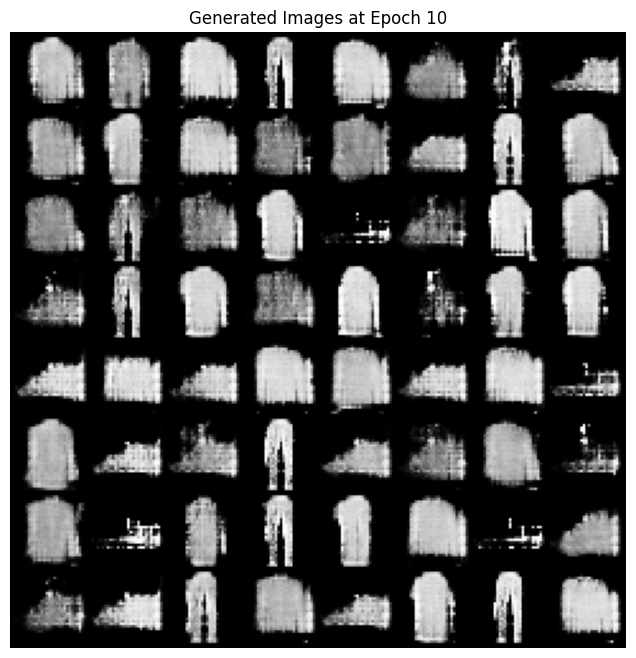

In [ ]:
epochs = 100

for epoch in range(epochs):
    for idx, (data, label) in enumerate(dataloader):
        
        # Create Labels
        real_labels = torch.ones(len(data), 1).to(device) # labels for data from dataset
        generated_labels = torch.zeros(len(data), 1).to(device) # labels for data generated by generator
        
        # Train the Discriminator
        output_d = discriminator(data.to(device))
        loss_d = criterion(output_d, real_labels) # Ensures discriminator learns to identify data from dataset
        
        z = torch.randn(len(data), random_noise_dim).to(device)
        z = z.view(len(data), random_noise_dim, 1, 1)
        
        g_imgs = generator(z)
        output_g = discriminator(g_imgs.detach()) # cut the computation graph of the generator block
        loss_g = criterion(output_g, generated_labels) # Ensures discriminator learns to identify data from generator
        
        disc_loss = loss_d + loss_g # Total discriminator loss
        
        optimizer_d.zero_grad()
        disc_loss.backward()
        optimizer_d.step()
        
        # Train the Generator
        z = torch.randn(len(data), random_noise_dim).to(device)
        z = z.view(len(data), random_noise_dim, 1, 1)
            
        for _ in range(5):
            g_imgs = generator(z)
            g_output = discriminator(g_imgs)
            g_loss = criterion(g_output, real_labels) # Tricking the discriminator
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
    
    if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], D_loss: {disc_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            show_generated_images(epoch+1, generator, fixed_random_samples)
            torch.cuda.empty_cache()
